# <center> Projet IOT : Géolocalisation d'appareil connecté <center>

**Attention :** Ce travail a été réalisé en python 3. et avec scikit-learn 0.18.1

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from geopy.distance import vincenty
from scipy import stats
plt.style.use('ggplot')

In [2]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

## Importation des données

In [3]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test_to_submit = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

In [4]:
df_mess_train.head()

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [5]:
pos_train.head(2)

,lat,lng
0,39.60669,-104.95849
1,39.60669,-104.95849


## Investigation des données

In [6]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [7]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


Afin d'observer les données spatialement, il est nécessaire de déterminer les distances parcourues par les signaux, i.e. entre les balises et les devices. L'histogramme ci-dessous permet de se rendre compte de la dispersion de ces distances.

In [8]:
df_mess_train["distance_to_bsid"] = Eval_geoloc(pos_train.ix[:,0], pos_train.ix[:,1],\
                                            df_mess_train.ix[:,6], df_mess_train.ix[:,7] )

In [9]:
df_mess_train[df_mess_train["distance_to_bsid"] > 400000]['bsid'].unique()

array([ 8355, 11007,  1594, 10151, 10162,  8451,  4993,  8560,  2293,
        4959, 10999,  1661,  8449,  4156,  4129,  1743,  4987,  1772,
        1796,  2707,  2943,  4123, 11951,  9784,  1092,  3848,  2803,
        2808,  3630,  2800,  3933,  3501,  4013,  1443,  1854,  7248], dtype=int64)

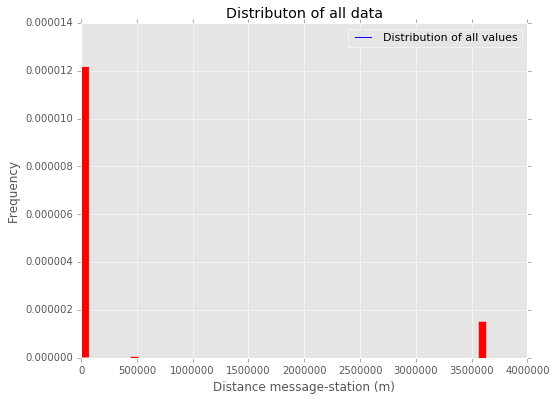

In [10]:
# Plot
X_axis_values = np.linspace(0, 1, 500)
kernel = stats.gaussian_kde(list(df_mess_train["distance_to_bsid"]))
fig = plt.figure(figsize=(8, 6))
plt.xlabel("Distance message-station (m)")
plt.ylabel("Frequency")
plt.title("Distributon of all data")
plt.hist(df_mess_train["distance_to_bsid"], bins=50, normed=True, color='r')
plt.plot(X_axis_values, kernel(X_axis_values), color='b', label='Distribution of all values')
plt.legend(fontsize='11')
plt.show()

Il y a 3 groupes très distincts au sein de la population initiale. La majorité des signaux sont perçus à une faible distance, inférieure à ~30km. Quelques signaux sont perçus à une distance d'environ 500km. Enfin, un nombre non négligeable de signaux sont perçus à plus de 3500 km par une ou plusieurs balises. Nous supposons qu'il s'agit de dispositifs utilisant des réseaux VPN. Par la suite, les données des deux derniers groupes sont écartéss car considérées comme bruit / valeurs aberrantes.

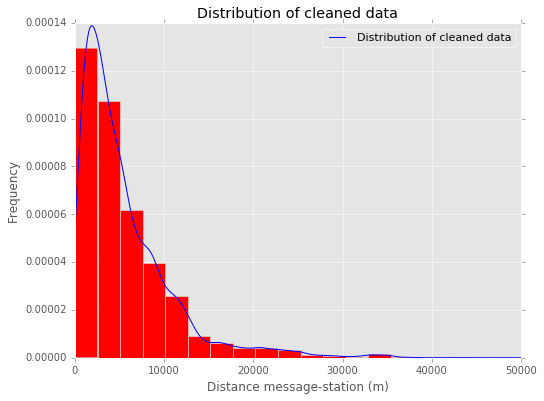

In [11]:
# Plot
X_axis_values = np.linspace(0,50000, 5000)
kernel = stats.gaussian_kde(list(df_mess_train[df_mess_train["distance_to_bsid"] <= 400000]["distance_to_bsid"]))
fig = plt.figure(figsize=(8, 6))
plt.xlabel("Distance message-station (m)")
plt.ylabel("Frequency")
plt.xlim(0,50000)
plt.title("Distribution of cleaned data")
plt.hist(df_mess_train[df_mess_train["distance_to_bsid"] <= 400000]["distance_to_bsid"], bins=150, normed=True, color='r')
plt.plot(X_axis_values, kernel(X_axis_values), color='b', label='Distribution of cleaned data')
plt.legend(fontsize='11')
plt.show()

Après avoir écarté les données concernant certains messages reçus sur des balises supposées trop lointaines (à plus de 400 km de distance), la distribution semble suffisamment épurée pour procéder à la suite de l'étude.

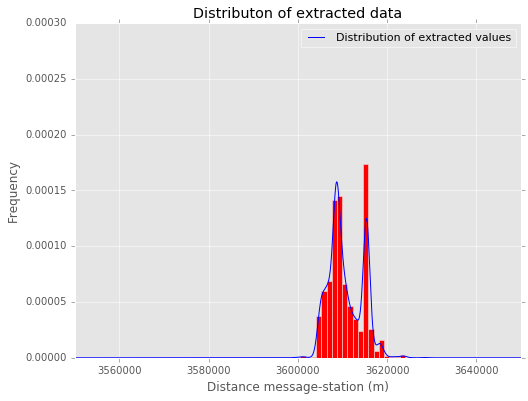

In [12]:
# Plot
X_axis_values = np.linspace(3400000, 3800000, 5000)
kernel = stats.gaussian_kde(list(df_mess_train[df_mess_train["distance_to_bsid"] >= 3550000]["distance_to_bsid"]))
fig = plt.figure(figsize=(8, 6))
plt.xlabel("Distance message-station (m)")
plt.ylabel("Frequency")
plt.xlim(3550000,3650000)
plt.ylim(0,0.0003)
plt.title("Distributon of extracted data")
plt.hist(df_mess_train[df_mess_train["distance_to_bsid"] >= 3550000]["distance_to_bsid"], bins=25, normed=True, color='r')
plt.plot(X_axis_values, kernel(X_axis_values), color='b', label='Distribution of extracted values')
plt.legend(fontsize='11')
plt.show()

L'histogramme ci-dessus représente le second groupe résiduel (message reçue à 3500 km par une balise). Il semble que ces données soient liées à plusieurs balises situées aux coordonnées (64.3°N, 68.5°W) soit dans le grand nord canadien.

In [13]:
# determine all Base stations that received at least 1 message
listOfBs = np.union1d(np.unique(df_mess_train[df_mess_train["distance_to_bsid"] <= 400000]['bsid']), np.unique(df_mess_test_to_submit['bsid']))
print("Il y a " + str(len(listOfBs)) + " balises réceptrices au total dont " + \
      str(len(np.unique(df_mess_train[df_mess_train["distance_to_bsid"] <= 400000]['bsid']))) + " en entraînement et " +\
      str(len(np.unique(df_mess_test_to_submit['bsid']))) + " en test.")

Il y a 244 balises réceptrices au total dont 215 en entraînement et 168 en test.


## Pré-processing

Plusieurs pistes sont possibles pour établir une matrice de features sur laquelle entraîner un algorithme:
* mettre 1 si une station a reçu un signal (0 sinon)
* utiliser le RSSI reçu par la station si la station a reçu un signal (une valeur très faible sinon)
* utiliser la puissance reçue si la station a reçu un signal (une valeur très faible sinon)

La 2eme option a été choisie ici.

In [14]:
# Feature Matrix construction 
def feat_mat_const(df_mess_train, df_mess_test):
    
    # Utiliser le RSSI reçu par la station si la station a reçu un signal, 0 sinon
    df_mess_train["Feature"] = df_mess_train["rssi"]
    df_mess_test["Feature"] = df_mess_test["rssi"]
    
    # On concatène train et test : l'idée est d'avoir toutes les bsid dans un jeu de données
    df_total = pd.concat([df_mess_train, df_mess_test])
    
    # On fait un tableau croisé dynamique avec en ligne les messageid et en colonne les bsid
    df_total_pivot = df_total.pivot(index = "objid", columns = "bsid", values = "Feature")
        
    # On remplace les NaN par 0
    df_total_pivot[df_total_pivot.isnull()] = -300
    
    # On enlève les lignes (objid) correspondant au jeu de test
    # On pourrait probablement faire plus rapidement
    
    df_total_pivot_train = df_total_pivot.loc[df_mess_train['objid'].unique()]
    df_total_pivot_test = df_total_pivot.loc[df_mess_test['objid'].unique()]
    
    return df_total_pivot_train, df_total_pivot_test

In [15]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):
    
    res = pd.concat([df_mess_train.objid, pos_train], axis = 1).drop_duplicates()
    res.set_index(np.arange(0, len(res)))
    res.columns = ("objid", "lat", "lng")
    
    return res.lat, res.lng

In [16]:
df_mess_train_clean = df_mess_train[df_mess_train["distance_to_bsid"] <= 400000]
pos_train_clean = pos_train.ix[np.where(df_mess_train["distance_to_bsid"] <= 400000)[0],:]

df_feat_train, df_feat_test_to_submit = feat_mat_const(df_mess_train_clean, df_mess_test_to_submit)
print("dimension matrice de features : " + str(df_feat_train.shape))
print("dimension matrice de test à soumettre : " + str(df_feat_test_to_submit.shape))

C:\Users\Greg\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


dimension matrice de features : (5871, 244)
dimension matrice de test à soumettre : (5294, 244)


In [17]:
df_feat_train.head()

bsid,879,911,921,944,980,1012,1086,1092,1120,1131,...,9783,9899,9936,9941,9949,10134,10148,10151,10162,11007
objid,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,...,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0
573bf3533e952e19126b256a,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,...,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0
573c0cd0f0fe6e735a699b93,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,...,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0
573c1272f0fe6e735a6cb8bd,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,...,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0
573c8ea8864fce1a9a5fbf7a,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-141.0,-300.0,-300.0,-300.0,...,-300.0,-129.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0,-300.0


Il faut également exclure les positions correspondants aux informations qui ont été écartés en raison de la distance entre device et balise.

In [18]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train_clean, pos_train_clean)

In [19]:
print("dimension du vecteur des latitudes : " + str(ground_truth_lat.shape))

dimension du vecteur des latitudes : (5871,)


In [20]:
from sklearn.decomposition import PCA

nb_composantes_reduction = 122

pca = PCA(n_components=nb_composantes_reduction)
pca.fit(df_feat_train)

print("Inertie totale avec " + str(nb_composantes_reduction) + " composantes conservées : " + str(np.sum(pca.explained_variance_ratio_)))

Inertie totale avec 122 composantes conservées : 0.990180362765


On constate qu'il est possible de réduire les dimensions du problèmes à seulement 122 (soit moitié moins) tout en conservant 99% d'information (inertie totale). Ceci permettrait de s'affranchir de certaines dimensions qui interviennent peu ou sont redondantes (balises non sollicitées ou à proximité les unes des aures).
Cependant, parmi les balises non utilisées en entraînement, certaines sont sollicitées dans le jeu de test. Il a donc été jugé préférable de ne pas réduire l'espace.

In [21]:
#features = pca.transform(df_feat)

Les données ont étés centrées-réduites pour minimiser l'effet des valeurs trop extrêmes.

In [22]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
scaler.fit(df_feat_train)

df_feat_train = scaler.transform(df_feat_train)
df_feat_test_to_submit = scaler.transform(df_feat_test_to_submit)

Le jeu d'entrainement à été découpé en 80% réservé à la validation croisée et 20% pour la validation finale.

In [23]:
from sklearn import model_selection
X_train_lat, X_test_lat, y_train_lat, y_test_lat = model_selection.train_test_split(df_feat_train, ground_truth_lat, \
                                                                   train_size = 0.8, test_size=0.2, random_state=7)

X_train_lng, X_test_lng, y_train_lng, y_test_lng = model_selection.train_test_split(df_feat_train, ground_truth_lng, \
                                                                   train_size = 0.8, test_size=0.2, random_state=7)

#Checking if X_train_lat = X_train_lng and X_test_lat = X_test_lng!
(X_train_lat.all() == X_train_lng.all()).all(), (X_test_lat.all() == X_test_lng.all()).all()

(True, True)

## Fit d'un modèle

In [24]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Initializing models
svr_lat = SVR()
svr_lng = SVR()

shufflesplit = ShuffleSplit(n_splits=10, train_size=0.7, test_size=0.3)

# Used for a first search via CV to retain best param
# param_grid = {'C':[1,10,100], 'epsilon':[0.001,0.0001,0.0005], \
#              'gamma':[0.005,0.01,0.02]}

# Use this grid for correction
param_grid = {'C':[100], 'epsilon':[0.001], \
              'gamma':[0.005]}

modellat = GridSearchCV(estimator=svr_lat, param_grid=param_grid, n_jobs=-1, cv=shufflesplit, verbose=1)
modellng = GridSearchCV(estimator=svr_lng, param_grid=param_grid, n_jobs=-1, cv=shufflesplit, verbose=1)

In [25]:
modellat.fit(X_train_lat, y_train_lat)
y_pred_lat = modellat.best_estimator_.predict(X_test_lat)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.1min finished


In [26]:
modellng.fit(X_train_lng, y_train_lng)
y_pred_lng = modellng.best_estimator_.predict(X_test_lng)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.9min finished


La prédiction sur le jeu de test permet de valider le modèle et de juger sa précision. La prédiction sur le jeu d'entraînement permet d'attester que l'apprentissage du jeu initial a capturé correctement les données d'entraînement sans sur-apprentissage.

In [27]:
err_vec_test = Eval_geoloc(y_test_lat, y_test_lng, y_pred_lat, y_pred_lng)

err_vec_train = Eval_geoloc(y_train_lat, y_train_lng, \
                modellat.best_estimator_.predict(X_train_lat), modellng.best_estimator_.predict(X_train_lng))

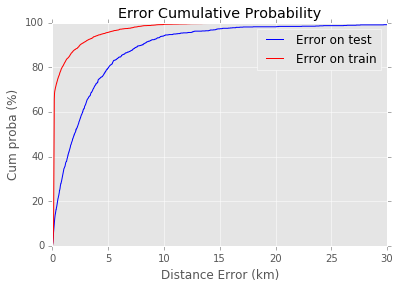

In [28]:
# Plot error distribution
values_test, base_test = np.histogram(err_vec_test, bins=50000)
cumulative_test = np.cumsum(values_test)
values_train, base_train = np.histogram(err_vec_train, bins=50000)
cumulative_train = np.cumsum(values_train)
plt.figure();
plt.plot(base_test[:-1]/1000, cumulative_test / np.float(np.sum(values_test))  * 100.0, c='blue')
plt.plot(base_train[:-1]/1000, cumulative_train / np.float(np.sum(values_train))  * 100.0, c='red')
plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Error on test", "Error on train"])

On constate que l'erreur à 80% sur le jeu de validation finale reste élevée mais inférieure à celle obtenue initialement (7500m).

In [29]:
# Error criterion
print("Error criterion at quantile 80 on training : " + str(np.percentile(err_vec_train, 80)) + " m.")

Error criterion at quantile 80 on training : 877.651496575 m.


In [30]:
# Error criterion
print("Error criterion at quantile 80 on validation-test : " + str(np.percentile(err_vec_test, 80)) + " m.")

Error criterion at quantile 80 on validation-test : 5049.83789377 m.


In [31]:
# retrain model on the full dataset
svr_lat = SVR(C=100, epsilon=0.001, gamma=0.005)
svr_lat.fit(df_feat_train, ground_truth_lat)

svr_lng = SVR(C=100, epsilon=0.001, gamma=0.005)
svr_lng.fit(df_feat_train, ground_truth_lng)

y_pred_lat = svr_lat.predict(df_feat_test_to_submit)
y_pred_lng = svr_lng.predict(df_feat_test_to_submit)

In [32]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res.head()

,lat,lng
0,39.676463,-105.046154
1,39.889777,-105.058690
2,39.690800,-105.007973
3,39.785238,-105.067992
4,39.691158,-105.006418


In [33]:
test_res.to_csv('pred_pos_test_list.csv', index=False)

In [34]:
test_res.describe()

,lat,lng
count,5294.000000,5294.000000
mean,39.742012,-105.049496
std,0.120104,0.094941
min,36.229940,-107.049860
25%,39.714835,-105.057081
50%,39.728789,-105.042917
75%,39.773078,-105.010733
max,42.377054,-102.528847


## Leave one out

In [35]:

def build_feat_pos_leave_one_out(df_mess_train, df_mess_test, pos_train, dev_id=476600.0):
    
    df_mess_train["Feature"] = df_mess_train["rssi"]
    df_mess_test["Feature"] = df_mess_test["rssi"]

    df_total = pd.concat([df_mess_train, df_mess_test])
    df_total_pivot = df_total.pivot_table(index = "objid", columns = "bsid", values = "Feature")
    
    df_total_pivot[df_total_pivot.isnull()] = -300
    
    # features for train and test
    df_pivot_train = df_total_pivot[df_total_pivot.index.isin(df_mess_train.objid.unique())]
    df_pivot_test = df_total_pivot[df_total_pivot.index.isin(df_mess_test.objid.unique())]
    
    # select one device by its id
    df_objid_did = df_mess_train[['objid', 'did']]
    df_objid_did['value'] = 1
    df_pivot_objid_did = pd.pivot_table(df_objid_did, index = "did", columns = "objid", values='value', fill_value=0)
    
    nb_dev = df_pivot_objid_did.shape[0]
    
    balise_row = df_pivot_objid_did.loc[dev_id]
    objid_dev = balise_row[balise_row == 1].index.values

    df_feat_0 = df_pivot_train.loc[objid_dev]
    df_feat_all_rest = df_pivot_train[~df_pivot_train.index.isin(objid_dev)]

    df_pos = pd.concat([df_mess_train.objid, pos_train], axis = 1).drop_duplicates()
    df_pos = df_pos.set_index('objid')
    df_pos.columns = ('lat', 'lng')
    
    df_pos_0 = df_pos.loc[objid_dev]
    
    df_pos_all_rest = df_pos[~df_pivot_train.index.isin(objid_dev)]

    return df_feat_all_rest.values, df_feat_0.values, df_pos_all_rest.values, df_pos_0.values, dev_id


X_all_rest, X_dev, y_all_rest, y_dev, dev_id = build_feat_pos_leave_one_out(df_mess_train_clean, df_mess_test_to_submit, pos_train_clean)
print('We left out the device number {:} and build the features matrix, there are {:} messages from this device.'.format(dev_id, y_dev.shape[0]))


C:\Users\Greg\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Greg\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We left out the device number 476600.0 and build the features matrix, there are 56 messages from this device.


In [36]:
# fit and predict on the left out device

svr_lat = SVR(C=100, epsilon=0.001, gamma=0.005)
svr_lat.fit(X_all_rest, y_all_rest[:, 0])

svr_lng = SVR(C=100, epsilon=0.001, gamma=0.005)
svr_lng.fit(X_all_rest, y_all_rest[:, 1])

y_pred_lat = svr_lat.predict(X_dev)
y_pred_lng = svr_lng.predict(X_dev)

err_vec_test_dev = Eval_geoloc(y_pred_lat, y_pred_lng, y_dev[:, 0], y_dev[:, 1])


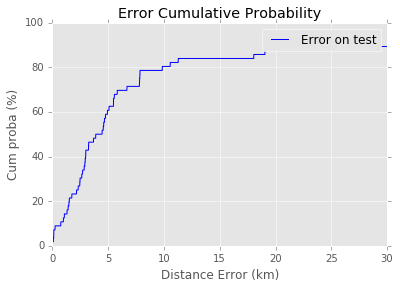

In [37]:
# Plot error distribution on the device
values_test_dev, base_test_dev = np.histogram(err_vec_test_dev, bins=50000)
cumulative_test_dev = np.cumsum(values_test_dev)
plt.figure();
plt.plot(base_test_dev[:-1]/1000, cumulative_test_dev / np.float(np.sum(values_test_dev))  * 100.0, c='blue')
plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Error on test", "Error on train"])

## Synthèse-Conclusion:

La matrice des features a été retraitée en effectuant un remplacement de la donnée binaire 0 ou 1 (associant une station de base et un objet lorsqu'un message a été échangé entre eux), par la valeur du RSSI lors de cet échange. Sans retraitement particulier, les valeurs inconnues de RSSI se trouvaient avec une valeur de 0 qui dans l'échelle de réception radio était une bonne valeur, cela a donc été remplacé par une valeur plus cohérente de -300 (double par rapport à la plus faible valeur de RSSI de l'ensemble d'entraînement).

Cette utilisation du RSSI a permis d'obtenir une première amélioration de la performance mesurée par la distance d'erreur.

La problématique de localisation des objets étant un problème de régression, les régresseurs LogisticRegression, KNN-R, et SVR-R ont été utilisés. Les meilleures performances ont été obtenues avec le SVR-R avec GridSearch pour trouver les meilleurs hyperparamètres, en prenant soin de calibrer le paramètre $\epsilon$ du modèle (représentant l'intervalle autour de la valeur cible pour lequel aucune pénalité n'est appliquée) de façon à être comparable à une petite distance dans le système de coordonnées WGS84. La distance d'erreur obtenue est de l'ordre de 800 mètres.
